# Model of the potassium A-type (transient) current


*equations taken from Sterratt et al. book*


\begin{equation}
C_m\frac{dV}{dt} = -\bar{g}_{Na}m^3h(V-E_{Na}) - \bar{g}n^4_K(V-E_K) - g_{lk}(V-E_{lk}) - I_A
\end{equation}


\begin{equation}
I_A = \bar{g}_Aa^3b(V-E_A);
\end{equation}


\begin{equation}
a_\infty  = \left(\frac{0.0761 \exp (\frac{V+99.22}{31.84}) }{1 + \exp(\frac{V+6.17}{28.93})} \right)^{1/3}\quad
\tau_a = 0.3632 + \frac{1.158}{1 + \exp(\frac{V+60.96}{20.12})}\;
\end{equation}

\begin{equation}
b_\infty = \frac{1}{\left(1 + \exp(\frac{V+58.3}{14.54})\right)^4}\;
\tau_b = 1.24 + \frac{2.678}{1 + \exp(\frac{V-55}{16.027})} 
\end{equation}


In [1]:
from __future__ import division

In [2]:
from PyDSTool import *
import PyDSTool as dst

In [3]:
%pylab inline

style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
import bokeh
import bokeh.plotting as bkp

from ipywidgets import interact
bkp.output_notebook()

BokehJS successfully loaded.

## Setting the model up

In [5]:
Acurr_params = dict(
    Iap = 0,
    Ena = 50,
    Ek = -77,
    Ea = -80,
    Elk = -22,
    gnabar = 120.,# mS/cm^2
    gkbar = 20.0, # mS/cm^2
    gabar = 47.7, # mS/cm^2
    glk = 0.3
)
Vtest = linspace(-100,50, 1000)

In [6]:
def ainf(Vm,vshift=5):
    return (0.0761*exp((Vm+vshift+94.22)/31.84)/(1+exp((Vm+vshift+1.17)/28.93)))**(1/3)
def atau(Vm, vshift=5):
    return 0.3632  + 1.158/(1 + exp((Vm+vshift + 55.96)/20.12))

In [7]:
def binf(Vm, vshift=5):
    return 1/(1 + exp((Vm+vshift + 53.3)/14.54))**4
def btau(Vm, vshift=5):
    return 1.24 + 2.678/(1 + exp((Vm-vshift+50)/16.027))

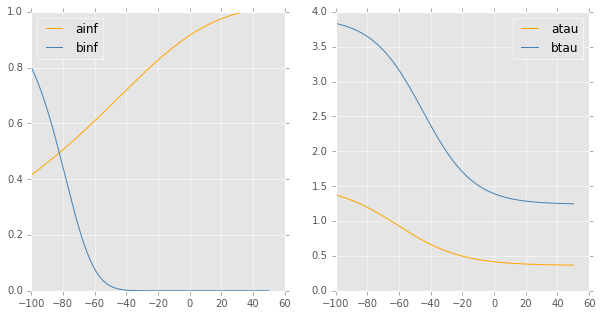

In [8]:
figure(figsize=(10,5))
subplot(121)
plot(Vtest, clip(ainf(Vtest),0,1), color="orange", label='ainf')
plot(Vtest, binf(Vtest), color="steelblue", label='binf')

legend(loc=0)

subplot(122)
plot(Vtest, atau(Vtest), color="orange", label='atau')
plot(Vtest, btau(Vtest), color="steelblue", label='btau')
legend()

In [9]:
q10 = 3.13
Q = q10**((18-6.3)/10) # = 3.8

def vtrap(x,y):
    return where(np.abs(x/y) < 1e-6, y*(1-0.5*x/y), x/(exp(x/y)-1))


def nalpha(Vm, nshift=0.7):
    return Q*0.5*0.01 * vtrap(-(Vm + 50 + nshift), 10)
  
def nalpha2(Vm, nshift=0.7):
    return Q*0.5*(-0.01) * (Vm+50.7)/(exp(-0.1*(Vm+50.7))-1)
    
def nbeta (Vm, nshift=0.7):
    return Q*0.5*0.125 * exp(-(Vm + 60 + nshift)/80)
        
        
        

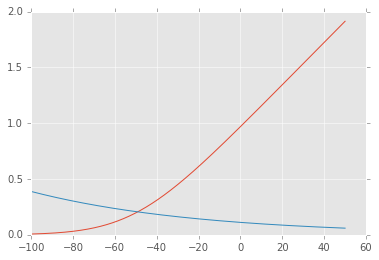

In [10]:
plot(Vtest, nalpha(Vtest), Vtest, nbeta(Vtest))#, Vtest, nalpha2(Vtest))

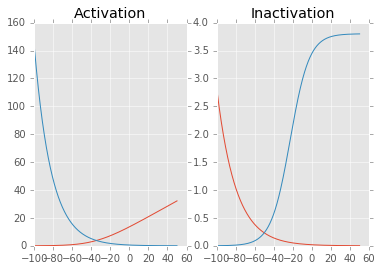

In [11]:
mshift = -0.3
hshift = -7

def malpha(Vm):
    return Q* 0.1 * vtrap(-(Vm + 35 + mshift), 10)
def mbeta(Vm):
    return Q* 4 * exp(-(Vm + 60 + mshift)/18)

def halpha(Vm):
    return Q* 0.07*exp(-(Vm + 60 + hshift)/20)
def hbeta(Vm):
    return Q* 1/(exp(-(Vm + 30 + hshift)/10) + 1)

def minf (V):
    return 1 / (1 + mbeta(V)/malpha(V))

def hinf(V):
    return 1/(1 + hbeta(V)/halpha(V))

def ninf(V):
    return 1/(1 + nbeta(V)/nalpha(V))

subplot(121)
plot(Vtest, malpha(Vtest), Vtest,mbeta(Vtest))
title('Activation')

subplot(122)
plot(Vtest, halpha(Vtest), Vtest,hbeta(Vtest))
title('Inactivation')

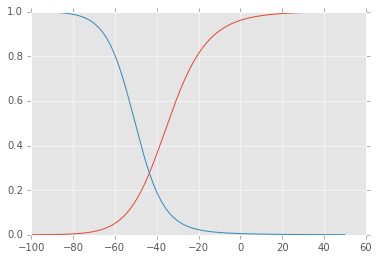

In [12]:

plot(Vtest, minf(Vtest), Vtest,hinf(Vtest))


In [13]:


DSargs = dst.args(name="Acurrent", 
                  pars = Acurr_params,
                  vars = ['V', 'm', 'h', 'n', 'a', 'b'],
                  tdomain=[0.0,1000.0])


DSargs.ics = dict(V = -75, 
                  m=0.1, 
                  h=0.1, 
                  n = 0.1,
                  a = 0.1, 
                  b = 0.1) # Initial conditions


DSargs.fnspecs = dict(ainf = (['V'], 'pow(0.0761*exp((V+99.22)/31.84)/(1 + exp((V+6.17)/28.93)),1./3)'),
                      atau = (['V'], '0.3632 + 1.158/(1 + exp((V+60.96)/20.12))'),
                      #
                      binf = (['V'], '1/(1 + exp((V+58.3)/14.54))**4'),
                      btau = (['V'], '1.24 + 2.678/(1 + exp((V-55)/16.027))'),
                      #
                      malpha = (['V'], '3.8 * (-0.1*(V+34.7))/(exp(-(V + 34.7)/10)-1)'),
                      mbeta = (['V'], '3.8 * 4 * exp(-(V+59.7)/18)'),
                      #
                      halpha =  (['V'], '3.8*0.07*exp(-(V+53)/20)'),
                      hbeta = (['V'], '3.8/(1 + exp(-(V+23)/10))'),
                      #
                      nalpha = (['V'], '0.5*3.8*(-0.01*(V+50.7))/(exp(-(V + 50.7)/10)-1)'),
                      nbeta = (['V'], '0.5*3.8*0.125*exp(-(V+60.7)/80)'),
                      #
                      rpulse = (['tx','width'], '0.5*(1 + tanh(100*(tx)) * tanh(100*(-tx+width)))'),
                     )

DSargs.varspecs = dict(
    V = 'Iap*rpulse((t-100), 800) -\
    (gnabar*m*m*m*h*(V-Ena) + gkbar*n*n*n*n*(V-Ek) + gabar*a*a*a*b*(V-Ea) + glk*(V-Elk))',
    m = 'malpha(V)*(1-m) - mbeta(V)*m',
    h = 'halpha(V)*(1-h) - hbeta(V)*h',
    n = 'nalpha(V)*(1-n) - nbeta(V)*n',
    a = '(ainf(V)-a)/atau(V)',
    b = '(binf(V)-b)/btau(V)')



In [14]:
                   
#ode  = dst.Generator.Radau_ODEsystem(DSargs)
#ode  = dst.Generator.Dopri_ODEsystem(DSargs)
ode = dst.Generator.Vode_ODEsystem(DSargs)
traj0 = ode.compute('init')
pts0 = traj0.sample(dt=0.1)
ode.set(ics = pts0[-1])

In [25]:
ode.set(pars = dict(Iap=8.3))
#ode.set(algparams=dict(max_pts=50000))
%time traj1 = ode.compute('test')
pts1 = traj1.sample(dt=0.1)

CPU times: user 4.15 s, sys: 16 ms, total: 4.17 s
Wall time: 4.12 s


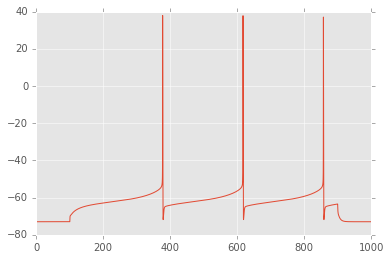

In [26]:
plot(pts1['t'], pts1['V'])